In [56]:
import os
import numpy as np
import cv2 # OpenCV
from sklearn.svm import SVC # SVM klasifikator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt

from joblib import dump, load

from htr import page_detection
from htr import word_detection
from htr import char_segmentation

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)


def implt(img, cmp=None, t=''):
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

def histogram_norm(img):
    img = bilateral_norm(img)
    add_img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img = 255 - img
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255        
    hist, bins = np.histogram(img.ravel(), 256, [0,256])
    
    img = img.astype(np.uint8)

    ret,thresh4 = cv2.threshold(img,np.argmax(hist)+10,255,cv2.THRESH_TOZERO)
    return add_img
    return cv2.add(add_img, thresh4, dtype=cv2.CV_8UC1)

def bilateral_norm(img):
    img = cv2.bilateralFilter(img, 9, 15, 30)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def display_image(image):
    plt.imshow(image, 'gray')

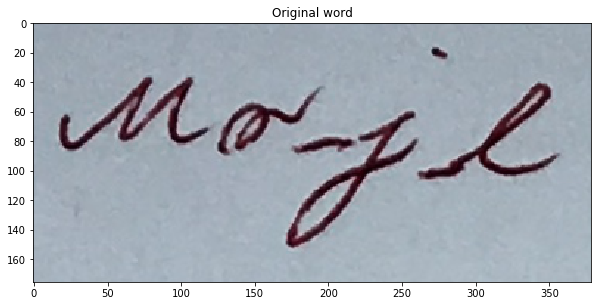

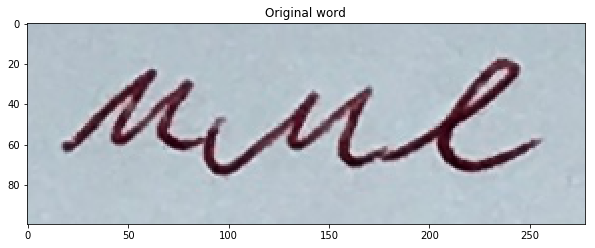

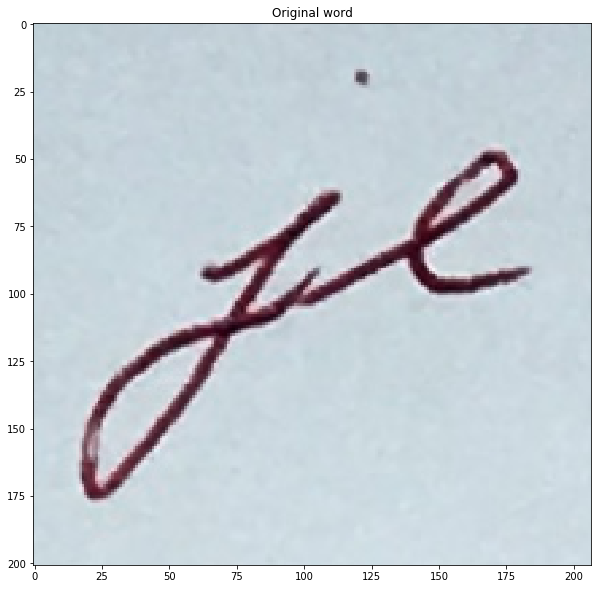

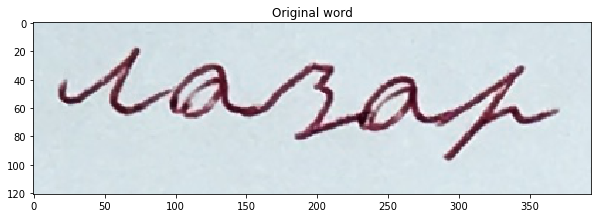

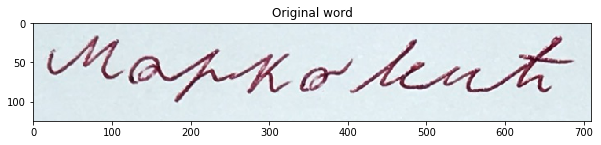

In [57]:
path = "./data/my-pages/t1.jpg"
image = page_detection.detect(path)

# Detected page
#implt(image)

# Words detected
word_imgs = word_detection.detect(image)

seg_words = []

for word in word_imgs:
    # Select some word
    img_copy = word.copy()
    implt(img_copy, cmp='gray', t='Original word')
    # Segment it
    segments = char_segmentation.segment(img_copy)
    seg_words.append(segments)

#for s in segments:
#    implt(s, cmp='gray', t='Char')

In [58]:
# Load training set
NUMBER_OF_RECURRENCES = 100
NUMBER_OF_SETS = 3
sets = []

for i in range(NUMBER_OF_SETS):
    for j in range(NUMBER_OF_RECURRENCES):
        train_dir = 'training_data/mala' + str(i+1) + '/'

        imgs = []
        count = 0
        while count <= 29:
            img_path = os.path.join(train_dir, str(count) + '.jpg')
            img = cv2.imread(img_path)
            imgs.append(img)
            count += 1

        sets.append(imgs)
    print("LOADED: training set ", i+1, '--', NUMBER_OF_RECURRENCES, 'times')

LOADED: training set  1 -- 100 times
LOADED: training set  2 -- 100 times
LOADED: training set  3 -- 100 times


In [65]:
# Load test set
test_dir = 'training_data/test_set/'
test_set = []

count = 0
while count <= 29:
    img_path = os.path.join(test_dir, str(count) + '.jpg')
    img = cv2.imread(img_path)
    test_set.append(img)
    count += 1
print("LOADED: test set")

LOADED: test set


In [66]:
# Define descriptor
nbins = 9 # broj binova
cell_size = (8, 8) # broj piksela po celiji
block_size = (3, 3) # broj celija po bloku

hog = cv2.HOGDescriptor(_winSize=(43 // cell_size[1] * cell_size[1], 
                                  43 // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

In [67]:
# Create training descriptor 
features = []
labels = []

for s in sets:
    c_num = 0
    for img in s:
        features.append(hog.compute(img))
        labels.append(c_num)
        c_num += 1

x_train = np.array(features)
y_train = np.array(labels)

print("Training descriptors created")

Training descriptors created


In [68]:
# Create test descriptor 
test_features = []
test_labels = []

print(len(test_set))

c_num = 0
for img in test_set:
    test_features.append(hog.compute(img))
    test_labels.append(c_num)
    c_num += 1

x_test = np.array(test_features)
y_test = np.array(test_labels)

print("Test descriptors created")

30
Test descriptors created


In [69]:
# transformisemo u oblik pogodan za scikit-learn
def reshape_data(input_data):
    nsamples, nx, ny = input_data.shape
    return input_data.reshape((nsamples, nx*ny))

x_train = reshape_data(x_train)
x_test = reshape_data(x_test)

print('Train shape: ', x_train.shape, y_train.shape)
print('Test shape: ', x_test.shape, y_test.shape)

Train shape:  (9000, 729) (9000,)
Test shape:  (30, 729) (30,)


In [70]:
clf_svm = SVC(kernel='linear', probability=True) 
clf_svm.fit(x_train, y_train)
y_train_pred = clf_svm.predict(x_train)
y_test_pred = clf_svm.predict(x_test)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

Train accuracy:  1.0
Validation accuracy:  0.8333333333333334


In [ ]:
# Save model
dump(clf_svm, './models/model1.ai') 



In [3]:
# Load model
clf_svm = load('./models/model1.ai') 

In [71]:
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn = clf_knn.fit(x_train, y_train)
y_train_pred = clf_knn.predict(x_train)
y_test_pred = clf_knn.predict(x_test)
print("Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation accuracy: ", accuracy_score(y_test, y_test_pred))

Train accuracy:  1.0
Validation accuracy:  0.8333333333333334


In [72]:
label_map = {1: 'а', 2: 'б', 3:'в', 4:'г', 5:'д', 6:'ђ', 7:"е", 8:'ж', 9:"з", 10:"и", 11:"ј", 12:"к", 13:"л", 14:"љ", \
             15:"м", 16:"н", 17:"њ", 18:"о", 19:"п", 20:"р", 21:"с", 22:"т", 23:"ћ", 24:"у", 25:"ф", 26:"х", 27:"ц", \
             28:"ч", 29:"џ", 30:"ш" }

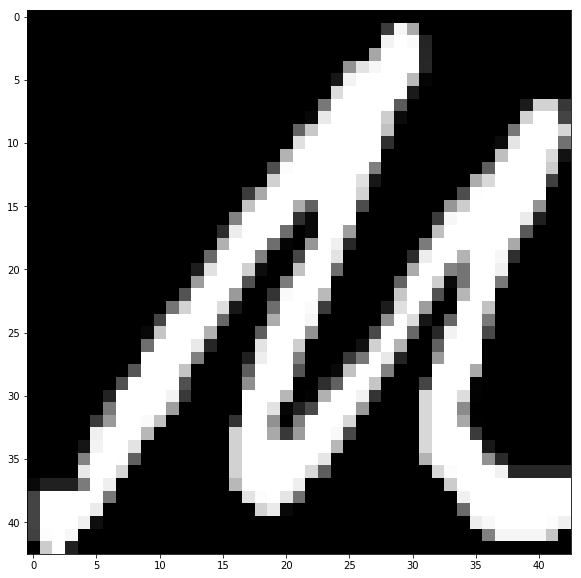

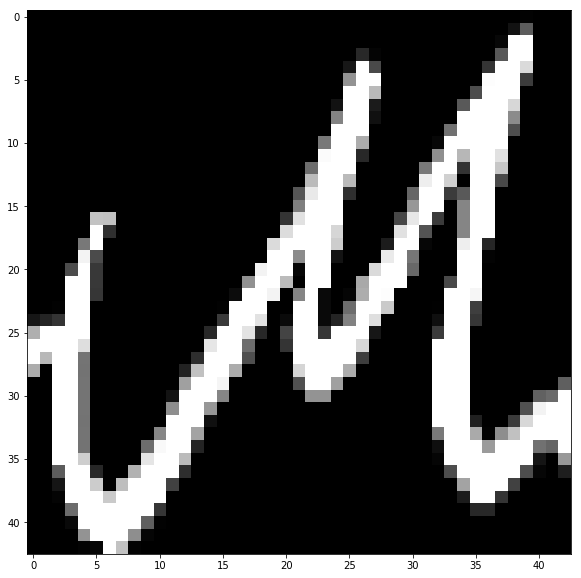

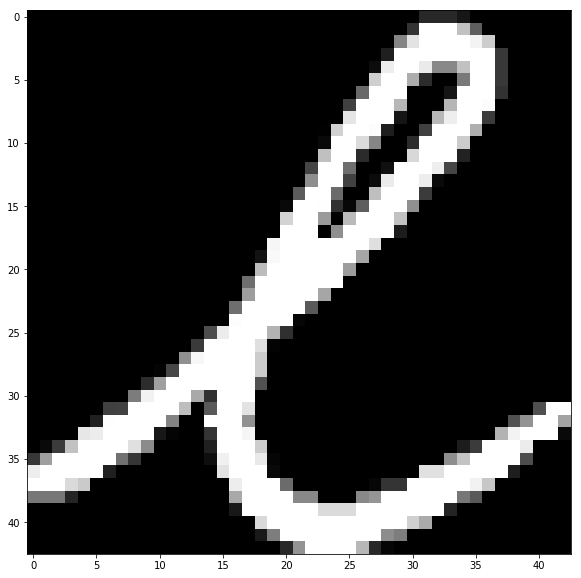

['вле ']


In [73]:
result_word_strings = []

#for sw in seg_words:

sw = seg_words[1]

word = ''
for c in sw:
    implt(c, 'gray')
    feat = hog.compute(c)
    feat = np.array(feat)
    feat = feat.reshape(1,-1)
    t =  clf_svm.predict(feat)
    word += label_map[t[0]+1]

result_word_strings.append(word + ' ')
        
print(result_word_strings)

In [74]:
path = "./training_data/mala3/6.jpg"
img = cv2.imread(path)

feat = hog.compute(img)
feat = np.array(feat)
feat = feat.reshape(1,-1)
t1 =  clf_svm.predict(feat)
t2 = clf_knn.predict(feat)
print('RESULT-SVM: ', label_map[t1[0]+1])
print('RESULT-KNN: ', label_map[t2[0]+1])

RESULT-SVM:  е
RESULT-KNN:  е
